In [ ]:
# Standard Library
import os
import os.path as op
import sys
import platform
import glob
import re
import shutil
import time as tm
from pathlib import Path
import pickle

# Core Scientific Stack
import numpy as np
import numpy.matlib
import pandas as pd
import scipy.signal as sgn
import scipy.stats as sts
from scipy.stats import circmean, circvar, circstd
from astropy.stats import rayleightest, vtest, circcorrcoef
from scipy.io import savemat, loadmat

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import nilearn
from nilearn import plotting
from nilearn.plotting import plot_anat
from nilearn.image import new_img_like
from scipy.ndimage import gaussian_filter1d

# MNE & BIDS
import mne
from mne import viz
from mne.viz import plot_alignment
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    write_raw_bids,
    write_anat,
    get_anat_landmarks,
    convert_montage_to_mri,
    convert_montage_to_ras,
    template_to_head,
    print_dir_tree,
    search_folder_for_text,
)
from mne_bids.stats import count_events
from mne import read_epochs
from mne.decoding import SlidingEstimator,GeneralizingEstimator

# Time-Frequency Analysis
import nitime.algorithms as tsa

# Machine Learning / Decoding
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVR, SVC
from joblib import Parallel, delayed

# Deep Learning 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Custom Toolbox
sys.path.append('/archive/intracranial/decoding_toolbox')  # Adjust if needed
import DecToolbox as dt

sys.path.append('/archive/intracranial/decoding_toolbox/Helper_funcs')
from base_stats import corr_linear_circular
from classifier_funcs import AngularRegression, SVR_polar, scorer_angle

# Other
import loess
from statsmodels.nonparametric.smoothers_lowess import lowess

import re
import nibabel as nib
from nilearn import plotting

In [2]:
#ID_list = ['RP022023C', 'PB052023', 'LVM062023', 'VG102023', 'WAB112023C', 'MPCN012024C', 'MFA022024C', 'MB052024C', 'GG062024C', 'SH09292', 'M102024C', 'IBR0125C', 'APG0225C']
#participant_list = ['s02', 's03', 's04', 's05', 's06', 's07', 's08', 's10', 's11', 's12', 's13', 's14', 's15']

ID_list = ['WAB112023C','MFA022024C']
participant_list = ['s06','s08']

ID_list_tms = ['XXXX','AJ102022C','IM112022C']
participant_list_tms = ['S01','S03','S04']

Exp_Modality = 'iEEG'
Exp_ID = 'EXP01'
participant = 's06'
sub_participant = f"sub-{participant}"
ID ='WAB112023C'
subject_ID =  ID + participant
session_n = '01'
task_n = 'iEEGwmprior'

raw_epochs_filename_fif = f"epochs_raw_clean_{participant}prior-epo.fif"
artifact_detection_epochs_filename_fif = f"epochs_{participant}prior_cleaned-epo.fif"
auto_reject_epochs_filename_fif = f"autoreject_epochs_{participant}-epo.fif"

raw_epochs_filename_tms_fif = f"epochs_raw_clean_{participant}tms-epo.fif"
artifact_detection_epochs_filename_tms_fif = f"epochs_{participant}tms_cleaned-epo.fif"
auto_reject_epochs_filename_tms_fif = f"autoreject_epochs_{participant}-epo.fif"

In [4]:
sys_dir = os.path.join('/archive','intracranial') 
mne_dir = os.path.join(sys_dir,'Exp_3_WM_prior')  
ravecsv = os.path.join(sys_dir,'rave_data','data_dir','CLINIC_PATIENTS',ID,'rave','meta','electrodes.csv')
fs_dir = os.path.join(sys_dir,'rave_data','raw_dir',ID,'rave-imaging','fs') 
bids_dir = os.path.join(mne_dir, 'raw_BIDS')
preproc_dir = os.path.join(mne_dir,'Preproc',participant,'data')  
raw_clean_path = os.path.join(preproc_dir, "raw_clean.fif")
freesurfer_path = os.path.join('/home','intracranial','freesurfer') 

raw_epochs_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Raw_Epochs',raw_epochs_filename_fif)
artifact_detection_epochs_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Artifact_Detection_Epochs',artifact_detection_epochs_filename_fif)
auto_reject_epochs_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Auto_Reject_Epochs',auto_reject_epochs_filename_fif)

raw_epochs_tms_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Raw_Epochs',raw_epochs_filename_tms_fif)
artifact_detection_epochs_tms_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Artifact_Detection_Epochs',artifact_detection_epochs_filename_tms_fif)
auto_reject_epochs_tms_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Auto_Reject_Epochs',auto_reject_epochs_filename_tms_fif)

analysis_dir = os.path.join(mne_dir , 'analysis','data_from_analysis')
results_dir = os.path.join(mne_dir , 'analysis','results')

In [ ]:
import os
import mne
from mne import concatenate_epochs

ID_list_prior         = ['WAB112023C', 'MFA022024C']
participant_list_prior= ['s06',       's08']

ID_list_tms           = ['XXXX',      'AJ102022C',  'IM112022C']
participant_list_tms  = ['S01',       'S03',        'S04']

mne_dir = os.path.join('/archive', 'intracranial', 'Exp_3_WM_prior')

epochs_raw_prior         = {}
epochs_artifact_prior    = {}
epochs_auto_reject_prior = {}

epochs_raw_tms           = {}
epochs_artifact_tms      = {}
epochs_auto_reject_tms   = {}

for ID, p in zip(ID_list_prior, participant_list_prior):
    raw_fn   = f"epochs_raw_clean_{p}prior-epo.fif"
    art_fn   = f"epochs_{p}prior_cleaned-epo.fif"
    auto_fn  = f"autoreject_epochs_{p}-epo.fif"

    raw_pth  = os.path.join(mne_dir, 'analysis', 'epochs', 'Raw_Epochs',            raw_fn)
    art_pth  = os.path.join(mne_dir, 'analysis', 'epochs', 'Artifact_Detection_Epochs', art_fn)
    auto_pth = os.path.join(mne_dir, 'analysis', 'epochs', 'Auto_Reject_Epochs',    auto_fn)

    print(f"Loading PRIOR epochs for {p} (ID={ID})…")
    epochs_raw_prior[p]         = mne.read_epochs(raw_pth)
    epochs_artifact_prior[p]    = mne.read_epochs(art_pth)
    epochs_auto_reject_prior[p] = mne.read_epochs(auto_pth)

for ID, p in zip(ID_list_tms, participant_list_tms):
    raw_fn   = f"epochs_raw_clean_{p}tms-epo.fif"
    art_fn   = f"epochs_{p}tms_cleaned-epo.fif"
    auto_fn  = f"autoreject_epochs_{p}-epo.fif"

    raw_pth  = os.path.join(mne_dir, 'analysis', 'epochs', 'Raw_Epochs',            raw_fn)
    art_pth  = os.path.join(mne_dir, 'analysis', 'epochs', 'Artifact_Detection_Epochs', art_fn)
    auto_pth = os.path.join(mne_dir, 'analysis', 'epochs', 'Auto_Reject_Epochs',    auto_fn)

    print(f"Loading TMS epochs for {p} (ID={ID})…")
    epochs_raw_tms[p]          = mne.read_epochs(raw_pth)
    epochs_artifact_tms[p]     = mne.read_epochs(art_pth)
    epochs_auto_reject_tms[p]  = mne.read_epochs(auto_pth)

epochs_raw_all         = {}
epochs_artifact_all    = {}
epochs_auto_reject_all = {}

all_participants = set(participant_list_prior) | set(participant_list_tms)
for p in all_participants:
    raws, arts, autos = [], [], []
    if p in epochs_raw_prior:         raws.append(epochs_raw_prior[p])
    if p in epochs_raw_tms:           raws.append(epochs_raw_tms[p])
    if p in epochs_artifact_prior:    arts.append(epochs_artifact_prior[p])
    if p in epochs_artifact_tms:      arts.append(epochs_artifact_tms[p])
    if p in epochs_auto_reject_prior: autos.append(epochs_auto_reject_prior[p])
    if p in epochs_auto_reject_tms:   autos.append(epochs_auto_reject_tms[p])

    epochs_raw_all[p]         = concatenate_epochs(raws)  if len(raws)  > 1 else raws[0]
    epochs_artifact_all[p]    = concatenate_epochs(arts)  if len(arts)  > 1 else arts[0]
    epochs_auto_reject_all[p] = concatenate_epochs(autos) if len(autos) > 1 else autos[0]

#### 21. Forward Encoding

In [6]:
def shrinkage_gamma(X, mem_eff=False, feedback=True):

    num_f, num_n = X.shape
    
    if not mem_eff:

        m = np.mean(X, axis=1, keepdims=True)
        S = np.cov(X, rowvar=True)
        nu = np.trace(S) / num_f

        z = np.zeros((num_f, num_f, num_n))
        for n in range(num_n):
            x_centered = X[:, n:n+1] - m
            z[:, :, n] = x_centered @ x_centered.T

        numerator = (num_n / ((num_n - 1) ** 2)) * np.sum(np.var(z, axis=2))
        denominator = np.sum((S - nu * np.eye(num_f)) ** 2)
        gamma = numerator / denominator
    
    else:

        X = X - np.mean(X, axis=1, keepdims=True)

        sum_var_diag = 0
        diag_s = np.zeros(num_f)
        
        for i_f in range(num_f):
            s = X[i_f, :] ** 2
            diag_s[i_f] = np.sum(s) / (num_n - 1)
            s_centered = s - np.mean(s)
            sum_var_diag += np.sum(s_centered ** 2) / (num_n - 1)
        
        nu = np.mean(diag_s)
        diag_s = diag_s - nu
        sum_s_diag = np.sum(diag_s ** 2)
        
        sum_s = 0
        sum_var = 0
        
        total_elements = (num_f - 1) * num_f // 2
        if feedback:
            print(f"Processing {total_elements} off-diagonal elements...")
        
        counter = 0
        for i_f1 in range(1, num_f):
            for i_f2 in range(i_f1):
                s = X[i_f1, :] * X[i_f2, :]
                sum_s += (np.sum(s) / (num_n - 1)) ** 2
                s_centered = s - np.mean(s)
                sum_var += np.sum(s_centered ** 2) / (num_n - 1)
                
                counter += 1
                if feedback and counter % 1000 == 0:
                    p_done = counter / total_elements
                    print(f"Progress: {p_done*100:.2f}% complete")
        
        sum_s = sum_s * 2 + sum_s_diag
        sum_var = sum_var * 2 + sum_var_diag
        gamma = (num_n / ((num_n - 1) ** 2)) * sum_var / sum_s
    
    return gamma

In [ ]:
from sklearn.model_selection import KFold
from mne import concatenate_epochs
import numpy as np
import os
import pickle

participants = list(epochs_raw_all.keys())

nfold = 3
kf = KFold(n_splits=nfold, shuffle=True, random_state=42)
cfg_design = {'kappa': 4, 'NumC': 10, 'Tuning': 'vonmises', 'offset': 0}

all_participant_summaries = []
all_participant_results   = {}

for participant in participants:

    ep_entry = epochs_raw_all[participant]
    if not isinstance(ep_entry, (list, tuple)):
        ep_list = [ep_entry]
    else:
        ep_list = ep_entry

    curr_ep = concatenate_epochs(ep_list).copy().resample(100)




    not_nan_mask = curr_ep.metadata['preT'].notna().values
    # apply it to epochs (this drops all NaN‐preT trials)
    curr_ep = curr_ep[not_nan_mask]
    # if you want, you can skip participants with no valid trials left
    if len(curr_ep) == 0:
        print(f"Participant {participant} has no valid preT trials, skipping.")
        continue




    times = curr_ep.times
    data  = curr_ep.get_data()
    phi   = curr_ep.metadata['preT'].values % 360

    bin_edges      = np.linspace(0, 360, cfg_design['NumC']+1)
    binned_phi     = np.digitize(phi, bins=bin_edges, right=False) - 1
    valid          = (binned_phi >= 0) & (binned_phi < cfg_design['NumC'])
    Y              = data[valid]
    X              = phi[valid]
    G              = binned_phi[valid]
    n_trials, n_channels, n_times = Y.shape

    time_resolved_r      = []
    time_resolved_tuning = []
    time_resolved_ci     = []

    x_labels = np.linspace(
        0,
        360*(cfg_design['NumC']-1)/cfg_design['NumC'],
        cfg_design['NumC']
    )

    for t_idx, t_center in enumerate(times):
        Y_t = Y[:, :, t_idx]
        Xhat_all, G_test_all, phi_test_all = [], [], []

        for train_idx, test_idx in kf.split(Y_t):
            Y_train = Y_t[train_idx]
            Y_test  = Y_t[test_idx]
            dat = {
                'X_train':   G[train_idx],
                'Y_train':   Y_train.T,
                'phi_train': X[train_idx],
                'X_test':    G[test_idx],
                'Y_test':    Y_test.T,
                'phi_test':  X[test_idx]
            }
            design, _ = dt.stim_features(dat['phi_train'], cfg_design)
            gamma_opt = shrinkage_gamma(Y_train, mem_eff=True, feedback=False)
            decoder   = dt.train_encoder(
                           design,
                           dat['Y_train'],
                           {'gamma': gamma_opt,
                            'demean': True,
                            'returnPattern': True}
                        )
            Xhat = dt.test_encoder(decoder, dat['Y_test'], {'demean': 'traindata'})
            Xhat_all.append(Xhat)
            G_test_all.append(dat['X_test'])
            phi_test_all.append(dat['phi_test'])

        Xhat    = np.concatenate(Xhat_all, axis=1)
        G_test  = np.concatenate(G_test_all)
        phi_test= np.concatenate(phi_test_all)

        numC = cfg_design['NumC']
        m_centered = np.zeros((numC, numC))
        for ic in range(numC):
            idx = np.where(G_test == ic)[0]
            if idx.size:
                m_centered[:, ic] = np.mean(
                    np.roll(Xhat[:, idx], -ic, axis=0),
                    axis=1
                )

        kernel = np.exp(1j * np.deg2rad(x_labels))
        Z = kernel @ Xhat
        theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi)
        r = np.abs(np.exp(1j * np.deg2rad(theta - phi_test)).mean())

        tuning_mean = m_centered.mean(axis=1)
        tuning_sem  = m_centered.std(axis=1) / np.sqrt(numC)
        ci_lower = tuning_mean - 1.96 * tuning_sem
        ci_upper = tuning_mean + 1.96 * tuning_sem

        time_resolved_r.append(r)
        time_resolved_tuning.append(tuning_mean)
        time_resolved_ci.append((ci_lower, ci_upper))

        all_participant_summaries.append({
            'participant': participant,
            'time_center': t_center,
            'r_value': r,
            'n_trials': n_trials,
            'n_channels': n_channels,
            'gamma': gamma_opt
        })

    # store per‐participant results including x_labels
    all_participant_results[participant] = {
        'times': times,
        'r_values': np.array(time_resolved_r),
        'tuning_curves': np.stack(time_resolved_tuning, axis=1),
        'confidence_intervals': time_resolved_ci,
        'x_labels': x_labels
    }

    out_dir = os.path.join(mne_dir, 'analysis', 'results', 'time_resolved_encoding_raw_pre')
    os.makedirs(out_dir, exist_ok=True)
    with open(os.path.join(out_dir, f"{participant}_results_pre.pkl"), 'wb') as f:
        pickle.dump(all_participant_results[participant], f)

summary_df = pd.DataFrame(all_participant_summaries)
summary_df.to_csv(os.path.join(out_dir, 'all_participants_summary_pre.csv'), index=False)

times = all_participant_results[participants[0]]['times']
r_matrix = np.stack([all_participant_results[p]['r_values'] for p in participants], axis=0)
mean_r = r_matrix.mean(axis=0)

tuning_stack = np.stack([all_participant_results[p]['tuning_curves'] for p in participants], axis=2)
mean_tuning = tuning_stack.mean(axis=2)

ci_lower_stack = np.stack([[ci[0] for ci in all_participant_results[p]['confidence_intervals']] for p in participants], axis=0)
ci_upper_stack = np.stack([[ci[1] for ci in all_participant_results[p]['confidence_intervals']] for p in participants], axis=0)
mean_ci_lower = ci_lower_stack.mean(axis=0)
mean_ci_upper = ci_upper_stack.mean(axis=0)

x_labels = all_participant_results[participants[0]]['x_labels']
group_results = {
    'times': times,
    'mean_r': mean_r,
    'mean_tuning': mean_tuning,
    'mean_ci': (mean_ci_lower, mean_ci_upper),
    'x_labels': x_labels
}


with open(os.path.join(out_dir, 'raw_time_resolved_results_pre.pkl'), 'wb') as f:
    pickle.dump(group_results, f)

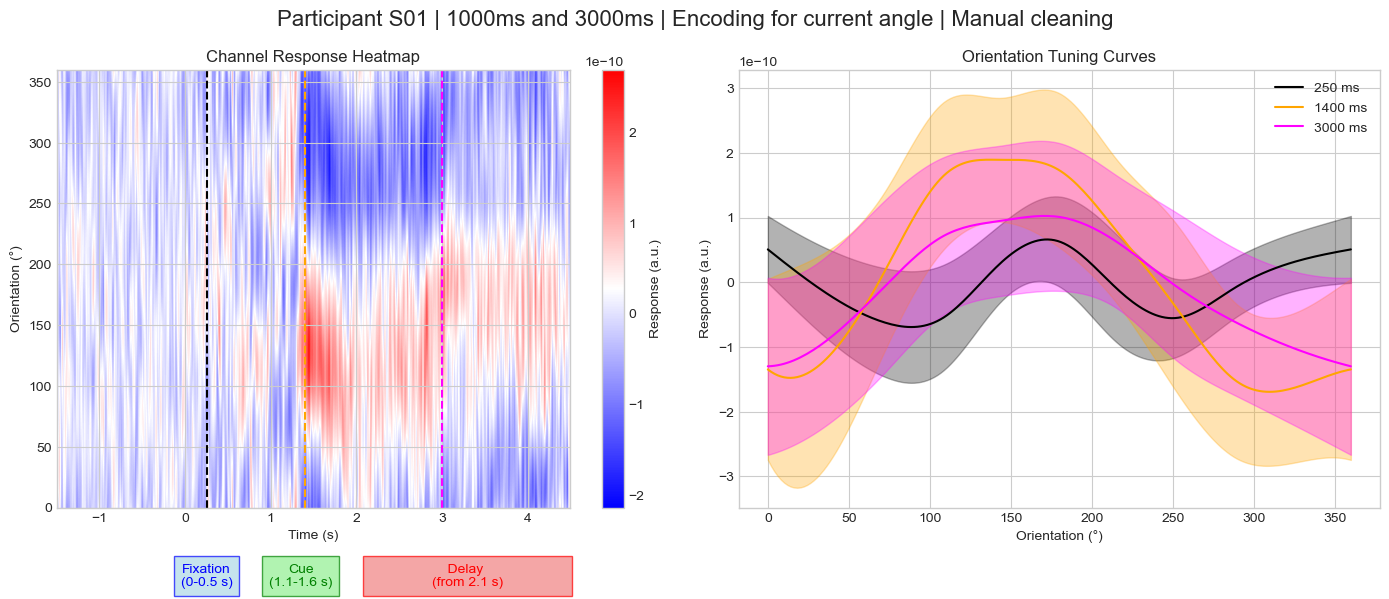

In [42]:
from scipy.interpolate import interp1d

participant   = 'S01'
delay_name    = '1000ms and 3000ms'
angle = 'current'
method = 'Manual cleaning'

results_dir = os.path.join(mne_dir,
                           'analysis',
                           'results',
                           'time_resolved_encoding_raw')
participant_results_path = os.path.join(
    results_dir,
    f"{participant}_results.pkl"
)

# Load results
with open(participant_results_path, 'rb') as f:
    results = pickle.load(f)

times                = results['times']                
tuning_curves        = results['tuning_curves']        
confidence_intervals = results['confidence_intervals'] 
x_labels             = results['x_labels']             


dense_x = np.linspace(0, 360, 180)
heatmap_data_dense = []
for t_idx, t_center in enumerate(times):
    curve = tuning_curves[:, t_idx]
    interp = interp1d(
        np.append(x_labels, 360),
        np.append(curve, curve[0]),
        kind='cubic'
    )
    heatmap_data_dense.append(interp(dense_x))
heatmap_data_dense = np.vstack(heatmap_data_dense)  

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"Participant {participant} | {delay_name} | Encoding for {angle} angle | {method}", fontsize=16)

im = axs[0].imshow(
    heatmap_data_dense.T,              
    aspect='auto',
    origin='lower',
    extent=[times[0], times[-1], dense_x[0], dense_x[-1]],
    cmap='bwr',
    interpolation='bicubic'
)

axs[0].set_xlim(times[0], times[-1])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Orientation (°)')
axs[0].set_title('Channel Response Heatmap')
fig.colorbar(im, ax=axs[0], label='Response (a.u.)')

label_y_offset = -40  

# Fixation period
axs[0].annotate('Fixation\n(0-0.5 s)', 
                xy=((0+0.5)/2, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, label_y_offset), textcoords='offset points',
                ha='center', va='top', fontsize=10, color='blue',
                bbox=dict(facecolor='lightblue', alpha=0.7, edgecolor='blue', pad=5))

# Cue period  
axs[0].annotate('Cue\n(1.1-1.6 s)', 
                xy=((1.1+1.6)/2, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, label_y_offset), textcoords='offset points',
                ha='center', va='top', fontsize=10, color='green',
                bbox=dict(facecolor='lightgreen', alpha=0.7, edgecolor='green', pad=5))

# Delay period
axs[0].annotate(f'                    Delay                     \n(from 2.1 s)', 
                xy=((2.1+times[-1])/2, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, label_y_offset), textcoords='offset points',
                ha='center', va='top', fontsize=10, color='red',
                bbox=dict(facecolor='lightcoral', alpha=0.7, edgecolor='red', pad=5))

time_points_to_plot = [0.25, 1.4, 3]
line_colors = ['black', 'orange', 'magenta']
for tp, color in zip(time_points_to_plot, line_colors):
    axs[0].axvline(tp, linestyle='--', color=color)

for tp, color in zip(time_points_to_plot, line_colors):
    idx = np.argmin(np.abs(times - tp))
    curve = tuning_curves[:, idx]
    interp_curve = interp1d(
        np.append(x_labels, 360),
        np.append(curve, curve[0]),
        kind='cubic'
    )(dense_x)
    ci_low, ci_up = confidence_intervals[idx]
    ci_l_dense = interp1d(
        np.append(x_labels, 360),
        np.append(ci_low, ci_low[0]),
        kind='cubic'
    )(dense_x)
    ci_u_dense = interp1d(
        np.append(x_labels, 360),
        np.append(ci_up, ci_up[0]),
        kind='cubic'
    )(dense_x)
    axs[1].plot(dense_x, interp_curve, label=f'{int(tp*1000)} ms', color=color)
    axs[1].fill_between(dense_x, ci_l_dense, ci_u_dense, color=color, alpha=0.3)

axs[1].set_xlabel('Orientation (°)')
axs[1].set_ylabel('Response (a.u.)')
axs[1].set_title('Orientation Tuning Curves')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.15) 
plt.show()

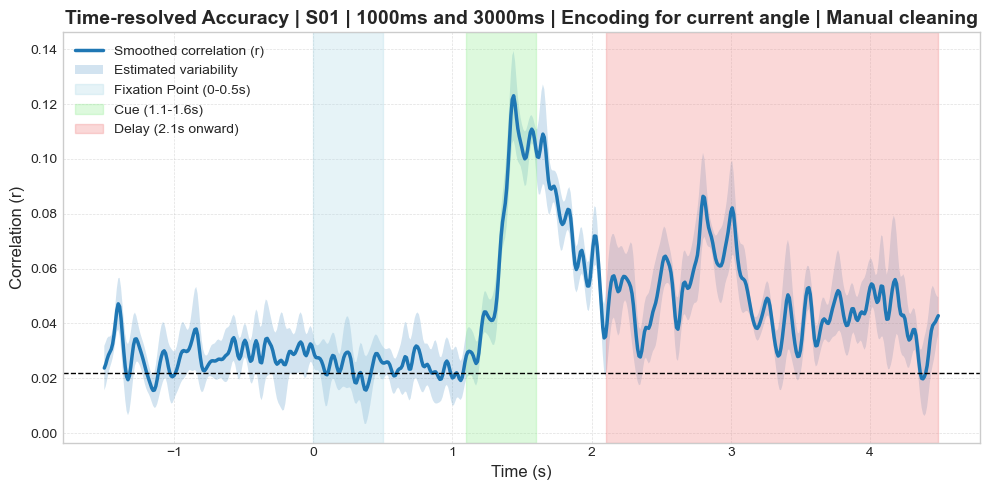

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

participant = 'S01'
delay_name    = '1000ms and 3000ms'
angle = 'current'
method = 'Manual cleaning'

results_dir = os.path.join(
    mne_dir,
    'analysis',
    'results',
    'time_resolved_encoding_raw'
)
participant_results_path = os.path.join(
    results_dir,
    f"{participant}_results.pkl"
)

with open(participant_results_path, 'rb') as f:
    results = pickle.load(f)

times    = results['times']      # shape (n_times,)
r_values = results['r_values']     # shape (n_times,)

smoothed_r = gaussian_filter1d(r_values, sigma=2)
residuals  = r_values - smoothed_r
local_std  = gaussian_filter1d(np.abs(residuals), sigma=2)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 5))

plt.plot(times, smoothed_r,
         label='Smoothed correlation (r)',
         linewidth=2.5)

plt.fill_between(times,
                 smoothed_r - local_std,
                 smoothed_r + local_std,
                 alpha=0.2,
                 label='Estimated variability')

plt.axvspan(0, 0.5, color='lightblue', alpha=0.3, label='Fixation Point')
plt.axvspan(1.1, 1.6, color='lightgreen', alpha=0.3, label='Cue')
plt.axvspan(2.1, times[-1], color='lightcoral', alpha=0.3, label='Delay')

plt.axhline(0.022, color='black', linestyle='--', linewidth=1)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Correlation (r)', fontsize=12)
plt.title(f'Time-resolved Accuracy | {participant} | {delay_name} | Encoding for {angle} angle | {method}',
          fontsize=14, weight='bold')
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Drop to localize

In [8]:
import os
import glob
import pandas as pd

bipolar_dir = '/archive/intracranial/Exp_3_WM_prior/analysis/bipolar_electrodes'

all_files = glob.glob(os.path.join(bipolar_dir, '*.csv'))

dfs = []
for fp in all_files:
    fn = os.path.basename(fp)
    if not fn.lower().startswith('bipolar_electrodes'):
        continue

    lfn = fn.lower()
    if 'prior' in lfn:
        condition = 'prior'
    elif 'tms' in lfn:
        condition = 'tms'
    else:
        # skip any file that has neither
        continue

    part = (fn
            .replace('bipolar_electrodes_', '')
            .replace(condition, '')
            .replace('_csv', '')
            .replace('.csv', '')
            .strip('_'))

    df = pd.read_csv(fp)
    df['participant'] = part
    df['condition']   = condition
    dfs.append(df)

if len(dfs) == 0:
    raise RuntimeError(f"No bipolar_electrodes files found in {bipolar_dir}")

all_bipolar = pd.concat(dfs, ignore_index=True)


In [23]:
target = ['S01']

records = []
for participant in target:
    raw_chs = set(epochs_raw_all[participant].ch_names)
    art_chs = set(epochs_artifact_all[participant].ch_names)
    dropped = raw_chs.difference(art_chs)
    for ch in dropped:
        records.append({'participant': participant, 'channel': ch})

missing_df = pd.DataFrame.from_records(records)

merged = missing_df.merge(
    all_bipolar[['participant', 'Bipolar_Label', 'FSLabel']],
    left_on  = ['participant', 'channel'],
    right_on = ['participant', 'Bipolar_Label'],
    how      = 'left'
)

result = (
    merged
    .loc[:, ['participant', 'channel', 'FSLabel']]
    .rename(columns={'FSLabel': 'anatomical_label'})
    .dropna(subset=['anatomical_label'])
    .reset_index(drop=True)
)

df = result.copy()
df['region'] = (
    df['anatomical_label']
      .str.replace(r'^Mixed:', '', regex=True)
      .str.split(r'\|')
).explode('region')

df = df.loc[~df['region'].str.contains('Unknown|White-Matter', na=False)]

clusters = (
    df
      .groupby('region')['channel']
      .apply(list)
      .reset_index(name='channels')
)

In [ ]:
import os
import pickle
import numpy as np
from sklearn.model_selection import KFold
from mne import concatenate_epochs

clusters = {
    'mid_cingulate':      ['OI9-OI10', 'OI2-OI3', 'AMD3-AMD4'],
    'primary_motor':      ['CMD5-CMD6', 'CMD6-CMD7', 'CMI11-CMI12',
                           'OI16-OI17', 'OI14-OI15'],
    'somatosensory':      ['AMI2-AMI3', 'AMI1-AMI2',
                           'CMI2-CMI3', 'CMD4-CMD5', 'OI1-OI2'],
    'medial_parietal':    ['CMD2-CMD3', 'CMD6-CMD7', 'AMSI1-AMSI2'],
    'intraparietal':      ['OI12-OI13', 'CAD7-CAD8', 'OI15-OI16'],
    'superior_temporal':  ['CMI3-CMI9', 'OI11-OI12', 'CMI1-CMI2'],
    'front_sup':          ['CPD1-CPD2']
}

raw_ep = concatenate_epochs([epochs_raw_all['S01']]).copy()
raw_ep.resample(100, npad='auto')
raw_ep.metadata = epochs_raw_all['S01'].metadata.copy()
mask = raw_ep.metadata['preT'].notna().values
raw_ep = raw_ep[mask]

nfold      = 3
kf         = KFold(n_splits=nfold, shuffle=True, random_state=42)
cfg_design = {'kappa': 4, 'NumC': 10, 'Tuning': 'vonmises', 'offset': 0}

out_dir = os.path.join(mne_dir, 'analysis', 'results',
                       'time_resolved_encoding_no_regions')
os.makedirs(out_dir, exist_ok=True)

for region, drop_chs in clusters.items():
    ep = raw_ep.copy()
    ep.drop_channels(drop_chs)
    
    times = ep.times
    data  = ep.get_data()                       
    phi   = ep.metadata['preT'].values % 360
    
    bin_edges  = np.linspace(0, 360, cfg_design['NumC']+1)
    binned_phi = np.digitize(phi, bins=bin_edges, right=False) - 1
    valid      = (binned_phi >= 0) & (binned_phi < cfg_design['NumC'])
    Y          = data[valid]
    X          = phi[valid]
    G          = binned_phi[valid]
    n_trials, n_channels, _ = Y.shape
    
    time_resolved_r      = []
    time_resolved_tuning = []
    time_resolved_ci     = []
    x_labels = np.linspace(0,
                           360*(cfg_design['NumC']-1)/cfg_design['NumC'],
                           cfg_design['NumC'])
    
    for t_idx in range(len(times)):
        Y_t = Y[:, :, t_idx]
        Xhat_all, G_test_all, phi_test_all = [], [], []
        
        for train_idx, test_idx in kf.split(Y_t):
            Y_train = Y_t[train_idx]
            Y_test  = Y_t[test_idx]
            dat = {
                'X_train':   G[train_idx],
                'Y_train':   Y_train.T,
                'phi_train': X[train_idx],
                'X_test':    G[test_idx],
                'Y_test':    Y_test.T,
                'phi_test':  X[test_idx]
            }

            design, _ = dt.stim_features(dat['phi_train'], cfg_design)
            gamma_opt = shrinkage_gamma(Y_train, mem_eff=True, feedback=False)
            decoder   = dt.train_encoder(
                           design,
                           dat['Y_train'],
                           {'gamma': gamma_opt,
                            'demean': True,
                            'returnPattern': True}
                        )
            Xhat = dt.test_encoder(decoder,
                                   dat['Y_test'],
                                   {'demean': 'traindata'})
            
            Xhat_all.append(Xhat)
            G_test_all.append(dat['X_test'])
            phi_test_all.append(dat['phi_test'])
        
        Xhat    = np.concatenate(Xhat_all, axis=1)
        G_test  = np.concatenate(G_test_all)
        phi_test= np.concatenate(phi_test_all)
        
        kernel = np.exp(1j * np.deg2rad(x_labels))
        Z      = kernel @ Xhat
        theta  = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi)
        r      = np.abs(np.exp(1j * np.deg2rad(theta - phi_test)).mean())
        
        numC       = cfg_design['NumC']
        m_centered = np.zeros((numC, numC))
        for ic in range(numC):
            idx = np.where(G_test == ic)[0]
            if idx.size:
                m_centered[:, ic] = np.mean(
                    np.roll(Xhat[:, idx], -ic, axis=0),
                    axis=1
                )
        tuning_mean = m_centered.mean(axis=1)
        tuning_sem  = m_centered.std(axis=1) / np.sqrt(numC)
        ci_lower    = tuning_mean - 1.96 * tuning_sem
        ci_upper    = tuning_mean + 1.96 * tuning_sem
        
        time_resolved_r.append(r)
        time_resolved_tuning.append(tuning_mean)
        time_resolved_ci.append((ci_lower, ci_upper))
    
    results = {
        'region': region,
        'times': times,
        'r_values': np.array(time_resolved_r),
        'tuning_curves': np.stack(time_resolved_tuning, axis=1),
        'confidence_intervals': time_resolved_ci,
        'x_labels': x_labels,
        'n_trials': n_trials,
        'n_channels': n_channels
    }

    fname = os.path.join(out_dir, f"S01_no_{region}_results_pre.pkl")
    with open(fname, 'wb') as f:
        pickle.dump(results, f)